In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from collections import OrderedDict

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

import time
import tqdm

from torch.utils.data import DataLoader
import os

In [2]:
# 实现DenseBlock中的内部结构，这里是BN+ReLU+1x1 Conv+BN+ReLU+3x3 Conv结构，最后也加入dropout层以用于训练过程。
class _DenseLayer(nn.Sequential):
    """DenseBlock的基本单元(使用瓶颈层bottleneck layer)"""
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module("norm1", nn.BatchNorm2d(num_input_features))
        self.add_module("relu1", nn.ReLU(inplace=True))
        self.add_module("conv1", nn.Conv2d(num_input_features, bn_size*growth_rate,
                                           kernel_size=1, stride=1, bias=False))
        self.add_module("norm2", nn.BatchNorm2d(bn_size*growth_rate))
        self.add_module("relu2", nn.ReLU(inplace=True))
        self.add_module("conv2", nn.Conv2d(bn_size*growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = float(drop_rate)  #dropout就是为了减少过拟合而研究出的一种方法

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

In [3]:
# 实现DenseBlock模块，内部是密集连接方式（输入特征数线性增长）
class _DenseBlock(nn.Sequential):
    """DenseBlock"""
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features+i*growth_rate, growth_rate, bn_size,
                                drop_rate)
            self.add_module("denselayer%d" % (i+1), layer)

In [4]:
# 实现Transition层（过渡层），它主要是一个卷积层和一个池化层
class _Transition(nn.Sequential):
    """两个相邻的DenseBlock之间的过渡层"""
    def __init__(self, num_input_feature, num_output_features):
        super(_Transition, self).__init__()
        self.add_module("norm", nn.BatchNorm2d(num_input_feature))
        self.add_module("relu", nn.ReLU(inplace=True))
        self.add_module("conv", nn.Conv2d(num_input_feature, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module("pool", nn.AvgPool2d(2, stride=2))

In [5]:
# 实现DenseNet网络
# 当模型结构即含瓶颈层,又含压缩层时,我们记模型为DenseNet-BC
class DenseNet(nn.Module):
    "DenseNet-BC model"
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64,
                 bn_size=4, compression_rate=0.5, drop_rate=0, num_classes=1000):
        """        
        :param growth_rate: (int) DenseLayer中使用的过滤器数量，论文中的“k”
        :param block_config:(4个int的列表)每个DenseBlock的层数
        :param num_init_features:(int)第一个Conv2d中的过滤器数量
        :param bn_size:(int)瓶颈层使用的因子
        :param compression_rate:(浮动)过渡层使用的压缩率
        :param drop_rate:(浮动)每个DenseLayer之后的掉落率
        :param num_classes:(int)用于分类的类数量
        """
        super(DenseNet, self).__init__()
        # first Conv2d
        # OrderedDict按照有序插入顺序存储的有序字典
        self.features = nn.Sequential(OrderedDict([
            ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ("norm0", nn.BatchNorm2d(num_init_features)),
            ("relu0", nn.ReLU(inplace=True)),
            ("pool0", nn.MaxPool2d(3, stride=2, padding=1))
        ]))

        # DenseBlock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers, num_features, bn_size, growth_rate, drop_rate)
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features += num_layers*growth_rate
            if i != len(block_config) - 1:
                transition = _Transition(num_features, int(num_features*compression_rate))
                self.features.add_module("transition%d" % (i + 1), transition)
                num_features = int(num_features * compression_rate)

        # final bn+ReLU
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.features.add_module("relu5", nn.ReLU(inplace=True))

        # classification layer
        self.classifier = nn.Linear(num_features, num_classes)

        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.avg_pool2d(features, 7, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [6]:
def read_split_data(imgs, labels, val_ratio=0.2, plot=False):
    # random.seed(0)
    assert os.path.exists(imgs), "imgs root:{} does not exist".format(imgs)
    assert os.path.exists(labels), "imgs root:{} does not exist".format(labels)

    train_imgs_path = []
    train_labels = []
    val_imgs_path = []
    val_labels = []
    supported = ['.jpg', '.JPG']

    # 得到所有图片地址
    images_name = os.listdir(imgs)
    images = [os.path.join(imgs, img) for img in os.listdir(imgs)
              if os.path.splitext(img)[-1] in supported]
    # 得到所有图片label
    df = pd.read_csv(labels)
    # df.loc[df['is_male'] == 1,'is_male'] = 1
    df.loc[df['is_male'] == -1,'is_male'] = 0  # 女性从-1变为0，这样后面的target就不会因为-1而越界
    path_label_dict = {}
    for i in images_name:
        path_label_dict.update({os.path.join(imgs, i): df[df.image_id == i].iloc[0, 1]})

    # 按比例划分val
    val_num = len(images) * val_ratio
    val_path = random.sample(images, int(val_num))

    for img_path in images:
        if img_path in val_path:
            val_imgs_path.append(img_path)
            val_labels.append(path_label_dict[img_path])
        else:
            train_imgs_path.append(img_path)
            train_labels.append(path_label_dict[img_path])

    print("{} images were found in the dataset".format(len(images)))
    print("{} in train_set".format(len(train_labels)))
    print("{} in val_set".format(len(val_labels)))

    if plot:
        train_male_num = np.sum(np.array(train_labels) == 1)
        train_female_num = np.sum(np.array(train_labels) == 0) # 如果女性仍为-1，则此处需要变为-1
        val_male_num = np.sum(np.array(val_labels) == 1)
        val_female_num = np.sum(np.array(val_labels) == 0)
        print("train_male_num:",train_male_num)
        print("train_female_num:",train_female_num)
        print("val_male_num:",val_male_num)
        print("val_female_num:",val_female_num)
        x = ['train_man', 'train_female', 'val_man', 'val_female']
        y = [train_male_num, train_female_num, val_male_num, val_female_num]
        plt.bar(x, y, color=["deepskyblue", "tomato", "deepskyblue", "tomato"])
        for a, b, i in zip(x, y, range(len(x))):  # zip 函数
            plt.text(a, b, "%d" % y[i], ha='center', fontsize=12)  # plt.text 函数
        plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
        plt.title("Gender distribution of the data set") # 数据集性别分布
        plt.show()

    return train_imgs_path, train_labels, val_imgs_path, val_labels

In [7]:
class MyDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform=None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item):
        img = Image.open(self.image_path[item]).convert('RGB')
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode".format(self.image_path[item]))
        label = self.image_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [8]:
################################# 训 练 #################################
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))

# 运用gpu速度更快
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')
print("using device: ", device)

# 读取数据，构建dataset, dataloader
train_imgs_path = "/kaggle/input/bitmoji-faces-gender-recognition/BitmojiDataset/trainimages/"
train_labels_path = "/kaggle/input/bitmoji-faces-gender-recognition/train.csv"
model_save_path = "/kaggle/working/model_save/"

# model_save_path = "/kaggle/working/model_save"新建文件夹
os.makedirs(model_save_path)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

1.11.0
11.0
8005
Tesla P100-PCIE-16GB
using device:  cuda


3000 images were found in the dataset
2100 in train_set
900 in val_set
train_male_num: 996
train_female_num: 1104
val_male_num: 423
val_female_num: 477


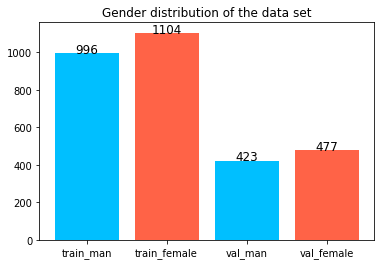

In [19]:
batch_size = 32
train_imgs, train_labels, val_imgs, val_labels = read_split_data(train_imgs_path, train_labels_path, val_ratio=0.3, plot=True)
train_dataset = MyDataset(train_imgs, train_labels, transform)
val_dataset = MyDataset(val_imgs, val_labels, transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

In [20]:
# 创建模型
model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), num_classes=2, num_init_features=64)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # 每3个epoch变为0.1倍

# 迭代15次
epochs = 15
num_iters = 0

train_losses = []
train_acc = []
val_acc = []
start_time = time.perf_counter()

In [22]:
for epoch in range(epochs):
        # train
        model.eval()
        train_pred_true_num = 0
        train_loss = []
        # tqdm 1
        loop = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), ncols=150)
        for _, (x, target) in loop:
            x = x.to(device)
            target = target.to(device)

            predict = model(x)
            loss = loss_fn(predict, target)
            train_pred_true_num += (predict.argmax(1) == target).sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_iters += 1
            train_losses.append(loss.item())
            train_loss.append(loss.item())

            # tqdm 2 更新信息
            loop.set_description(f'Epoch [{epoch+1}/{epochs}]')
            loop.set_postfix(loss=loss.item(), acc="{:.2f}%".format(train_pred_true_num / len(train_dataset)*100),
                             lr=f"{optimizer.param_groups[0]['lr']}",
                             running_time='{:.2f}s'.format(time.perf_counter()-start_time))
        scheduler.step()
        acc = train_pred_true_num / len(train_dataset)
        train_acc.append(acc)

        torch.save(model.state_dict(), os.path.join(model_save_path, "epoch_{}_{:.2f}%.pth".format(epoch+1, acc*100)))

        print("\nepoch{}: average_train_loss {}".format(epoch + 1, np.mean(train_loss)))
        print("epoch{}: train_acc {:.2f}%".format(epoch + 1, acc * 100))

        # test
        model.eval()
        val_pred_true_num = 0
        val_loss = []
        with torch.no_grad():
            for data in val_loader:
                imgs, targets = data
                imgs = imgs.to(device)
                targets = targets.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, targets)
                val_loss.append(loss.item())
                val_pred_true_num += (outputs.argmax(1) == targets).sum()
        acc = val_pred_true_num / len(val_dataset)
        val_acc.append(acc)

        print("\nepoch{}: average_test_loss:{}".format(epoch + 1, np.mean(val_loss)))
        print("epoch{}: val_acc:{:.2f}%".format(epoch + 1, acc * 100))

Epoch [1/15]: 100%|████████████████████████████████████████████| 66/66 [00:38<00:00,  1.70it/s, acc=64.57%, loss=0.498, lr=5e-05, running_time=40.36s]



epoch1: average_train_loss 0.6281553375901598
epoch1: train_acc 64.57%

epoch1: average_test_loss:0.4216991591042486
epoch1: val_acc:86.22%


Epoch [2/15]: 100%|████████████████████████████████████████████| 66/66 [00:23<00:00,  2.82it/s, acc=86.33%, loss=0.215, lr=5e-05, running_time=73.70s]



epoch2: average_train_loss 0.3500853165081053
epoch2: train_acc 86.33%

epoch2: average_test_loss:0.24537455855772414
epoch2: val_acc:90.33%


Epoch [3/15]: 100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.82it/s, acc=89.86%, loss=0.417, lr=5e-05, running_time=103.24s]



epoch3: average_train_loss 0.25217837535522203
epoch3: train_acc 89.86%

epoch3: average_test_loss:0.3975214418666116
epoch3: val_acc:86.11%


Epoch [4/15]: 100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.83it/s, acc=92.24%, loss=0.225, lr=5e-06, running_time=132.62s]



epoch4: average_train_loss 0.21166953060663107
epoch4: train_acc 92.24%

epoch4: average_test_loss:0.22885339681444497
epoch4: val_acc:90.44%


Epoch [5/15]: 100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.85it/s, acc=92.95%, loss=0.287, lr=5e-06, running_time=162.33s]



epoch5: average_train_loss 0.1885765894795909
epoch5: train_acc 92.95%

epoch5: average_test_loss:0.20839101339465585
epoch5: val_acc:91.22%


Epoch [6/15]: 100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.85it/s, acc=93.29%, loss=0.091, lr=5e-06, running_time=192.04s]



epoch6: average_train_loss 0.1806995536793362
epoch6: train_acc 93.29%

epoch6: average_test_loss:0.19929738021616278
epoch6: val_acc:91.67%


Epoch [7/15]: 100%|███████████████████████████| 66/66 [00:23<00:00,  2.82it/s, acc=93.62%, loss=0.186, lr=5.000000000000001e-07, running_time=221.91s]



epoch7: average_train_loss 0.1749528632922606
epoch7: train_acc 93.62%

epoch7: average_test_loss:0.19771382007105598
epoch7: val_acc:91.78%


Epoch [8/15]: 100%|████████████████████████████| 66/66 [00:23<00:00,  2.84it/s, acc=93.67%, loss=0.16, lr=5.000000000000001e-07, running_time=251.44s]



epoch8: average_train_loss 0.17442834778039745
epoch8: train_acc 93.67%

epoch8: average_test_loss:0.20003614953622736
epoch8: val_acc:91.44%


Epoch [9/15]: 100%|███████████████████████████| 66/66 [00:23<00:00,  2.80it/s, acc=93.57%, loss=0.126, lr=5.000000000000001e-07, running_time=281.12s]



epoch9: average_train_loss 0.17375716313042425
epoch9: train_acc 93.57%

epoch9: average_test_loss:0.19672273080153713
epoch9: val_acc:91.78%


Epoch [10/15]: 100%|██████████████████████████| 66/66 [00:23<00:00,  2.81it/s, acc=93.67%, loss=0.061, lr=5.000000000000001e-08, running_time=310.70s]



epoch10: average_train_loss 0.17199903489513832
epoch10: train_acc 93.67%

epoch10: average_test_loss:0.19719369818681273
epoch10: val_acc:91.67%


Epoch [11/15]: 100%|█████████████████████████| 66/66 [00:23<00:00,  2.81it/s, acc=93.81%, loss=0.0393, lr=5.000000000000001e-08, running_time=340.13s]



epoch11: average_train_loss 0.17175991810632474
epoch11: train_acc 93.81%

epoch11: average_test_loss:0.19738857872013388
epoch11: val_acc:91.89%


Epoch [12/15]: 100%|██████████████████████████| 66/66 [00:23<00:00,  2.78it/s, acc=93.81%, loss=0.213, lr=5.000000000000001e-08, running_time=370.07s]



epoch12: average_train_loss 0.17254131072849938
epoch12: train_acc 93.81%

epoch12: average_test_loss:0.1976739240746046
epoch12: val_acc:91.78%


Epoch [13/15]: 100%|█████████████████████████| 66/66 [00:23<00:00,  2.80it/s, acc=93.81%, loss=0.0993, lr=5.000000000000002e-09, running_time=399.99s]



epoch13: average_train_loss 0.17180871986078494
epoch13: train_acc 93.81%

epoch13: average_test_loss:0.1977162230759859
epoch13: val_acc:91.78%


Epoch [14/15]: 100%|██████████████████████████| 66/66 [00:23<00:00,  2.81it/s, acc=93.81%, loss=0.115, lr=5.000000000000002e-09, running_time=429.65s]



epoch14: average_train_loss 0.17188414857920373
epoch14: train_acc 93.81%

epoch14: average_test_loss:0.19767730817969503
epoch14: val_acc:91.78%


Epoch [15/15]: 100%|█████████████████████████| 66/66 [00:23<00:00,  2.79it/s, acc=93.81%, loss=0.0588, lr=5.000000000000002e-09, running_time=459.64s]



epoch15: average_train_loss 0.17155621415286354
epoch15: train_acc 93.81%

epoch15: average_test_loss:0.19769439884814724
epoch15: val_acc:91.78%


In [23]:
################################# 预 测 #################################
# 运用gpu速度更快
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("using device: ", device)

# 读取测试集
test_imgs_path = "/kaggle/input/bitmoji-faces-gender-recognition/BitmojiDataset/testimages"
test_labels_output_path = "/kaggle/input/bitmoji-faces-gender-recognition/sample_submission.csv"
df = pd.read_csv(test_labels_output_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

# 读取权值
weight_filepath = "/kaggle/working/model_save/epoch_11_93.81%.pth" # 要看文件名
model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), num_classes=2, num_init_features=64)
model.load_state_dict(torch.load(weight_filepath))
model.to(device)

using device:  cuda


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
cnt = 0
model.eval()
with torch.no_grad():
    for img_name in os.listdir(test_imgs_path):
        img_path = os.path.join(test_imgs_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        img = img.to(device).unsqueeze(0)
        pred = int(model(img).argmax(1))
        df.iloc[cnt, 1] = str(-1) if pred == 0 else str(1)
        cnt += 1
print(df)
df.to_csv("./sample_submission.csv",index=False,header=True)

      image_id is_male
0     3000.jpg      -1
1     3001.jpg       1
2     3002.jpg       1
3     3003.jpg      -1
4     3004.jpg      -1
...        ...     ...
1079  4079.jpg      -1
1080  4080.jpg       1
1081  4081.jpg       1
1082  4082.jpg       1
1083  4083.jpg      -1

[1084 rows x 2 columns]
